In [1]:
# ANNDL Homework 1 - Image Classification
# team: romano_ercolani
# Members: Romanò Francesco | Ercolani Antonio

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/MyDrive/CHALLENGE 1 - Image Classification

/gdrive/MyDrive/CHALLENGE 1 - Image Classification


In [5]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/Tomato/37979.jpg  
  inflating: training/Tomato/37980.jpg  
  inflating: training/Tomato/37982.jpg  
  inflating: training/Tomato/37983.jpg  
  inflating: training/Tomato/37984.jpg  
  inflating: training/Tomato/37985.jpg  
  inflating: training/Tomato/37988.jpg  
  inflating: training/Tomato/37989.jpg  
  inflating: training/Tomato/37990.jpg  
  inflating: training/Tomato/37992.jpg  
  inflating: training/Tomato/37993.jpg  
  inflating: training/Tomato/37994.jpg  
  inflating: training/Tomato/37995.jpg  
  inflating: training/Tomato/37996.jpg  
  inflating: training/Tomato/37997.jpg  
  inflating: training/Tomato/37998.jpg  
  inflating: training/Tomato/37999.jpg  
  inflating: training/Tomato/38000.jpg  
  inflating: training/Tomato/38001.jpg  
  inflating: training/Tomato/38003.jpg  
  inflating: training/Tomato/38004.jpg  
  inflating: training/Tomato/38005.jpg  
  inflating: training/Tomato/38006.jpg  
  infl

In [6]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [7]:
dataset_dir = 'training'

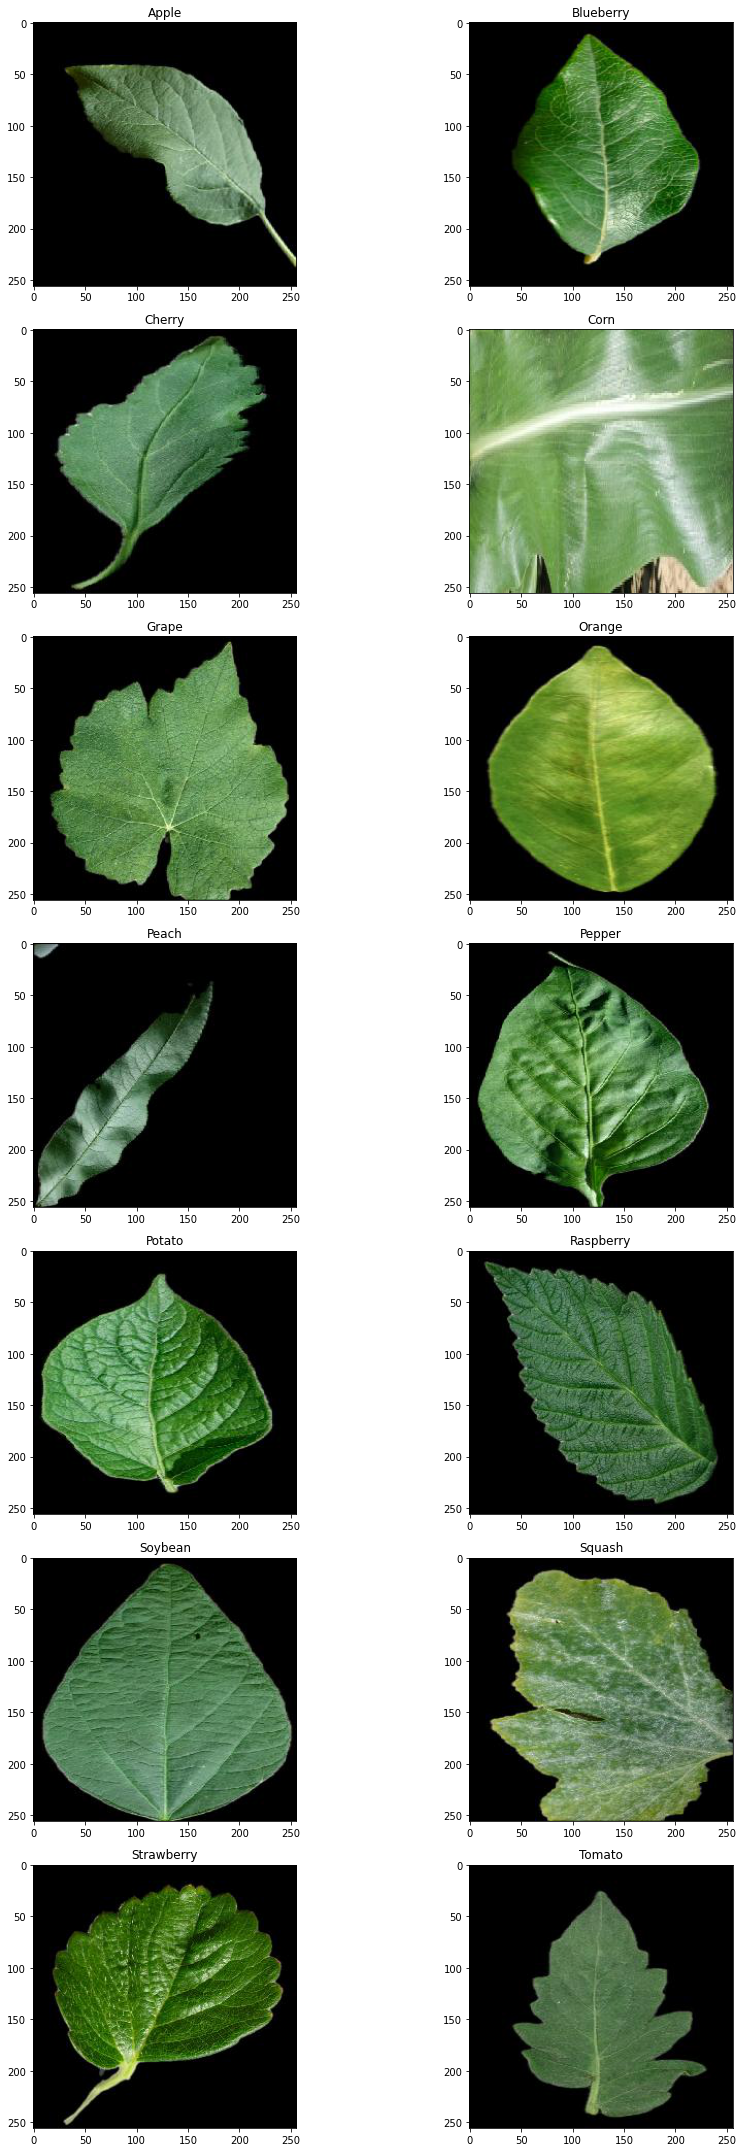

In [8]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [9]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [10]:
batch_size = 128

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#2 data generator since we aug ONLY the training set 

train_data_gen = ImageDataGenerator(rotation_range=30,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='constant', cval=0, # IN CLASS fill_mode='reflect'
                                    validation_split=0.2)

valid_data_gen = ImageDataGenerator(validation_split=0.2) 


aug_train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                         target_size=(256,256),
                                         color_mode='rgb',
                                         classes=None,
                                         class_mode='categorical',
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=seed,
                                         subset='training')

valid_gen = valid_data_gen.flow_from_directory(directory=dataset_dir,
                                         target_size=(256, 256),
                                         color_mode='rgb',
                                         classes=None,
                                         class_mode='categorical',
                                         batch_size=batch_size,
                                         shuffle=True,
                                         seed=seed,
                                         subset='validation')


Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


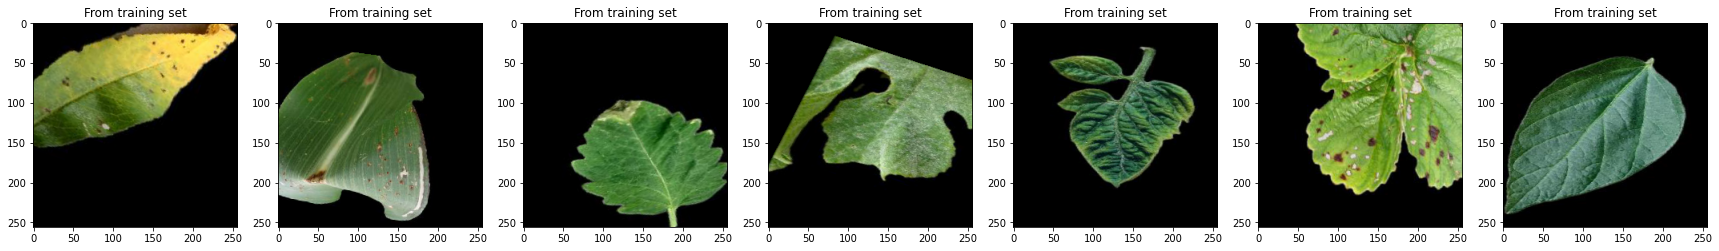

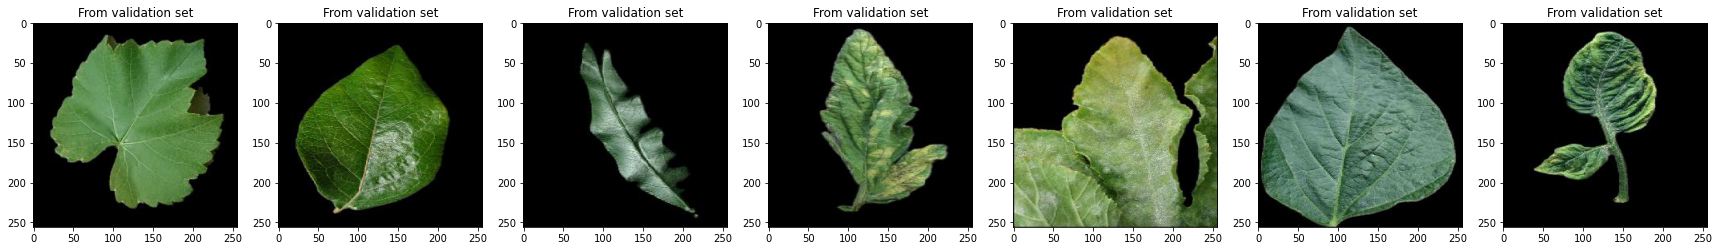

In [12]:
#explore training set and validation set
#only the images from training set should appear augmented 

train_batch = next(aug_train_gen)
valid_batch = next(valid_gen)

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(train_batch[0][i]))
  ax[i].set_title("From training set")

fig, ax = plt.subplots(1, 7, figsize=(30,45))
for i in range(0,7):
  ax[i].imshow(np.uint8(valid_batch[0][i]))
  ax[i].set_title("From validation set")

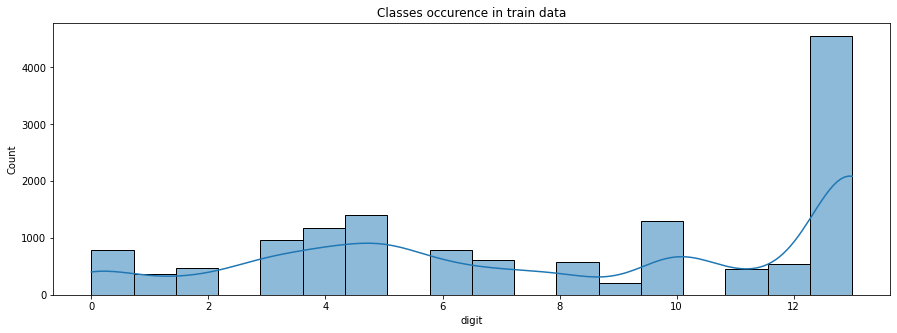

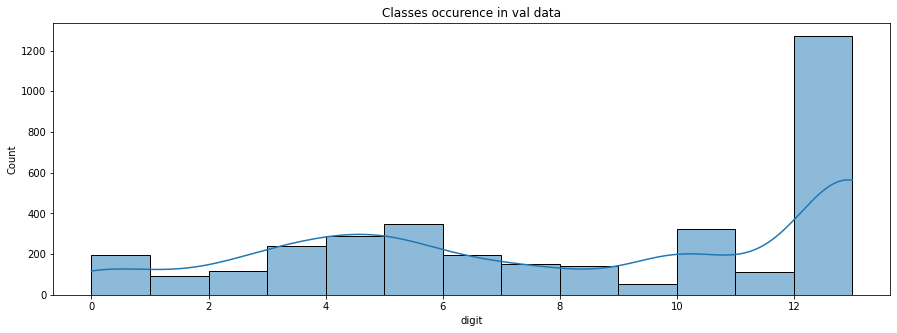

In [13]:
# Data exploration: check class distribution in training and validation data
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(aug_train_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in train data")
plt.show()

plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(valid_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in val data")
plt.show()

#Obs: class distribution is more or less preserved in train and val data

In [14]:
# Models metadata
input_shape = (256, 256, 3)
epochs = 200

# Transfer Learning VGG16

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

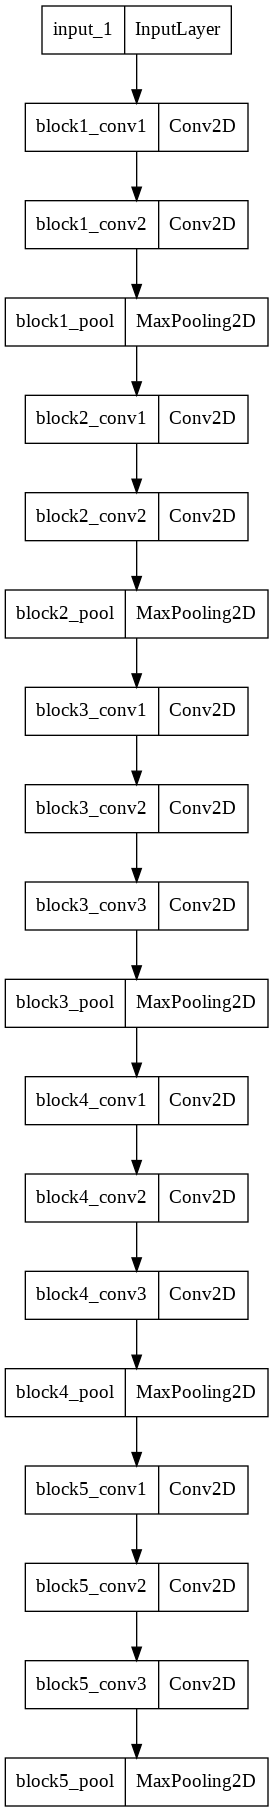

In [15]:
# Model transferred: vgg16
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [16]:
# Create the classifier dense top of vgg
# IN THIS NOTEBOOK WE TRY TO SET A HIGHER DROPOUT (0.6) AND A LOWER LEARNING RATE (0.0005)
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.6, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0005), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                             

In [17]:
# Considering class imbalance: class weightning
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.classes),
                                        y = aug_train_gen.classes                                                   
                                    )
class_weights = dict(zip(np.unique(aug_train_gen.classes), class_weights))
class_weights

{0: 1.2812895069532237,
 1: 2.7098930481283423,
 2: 2.170235546038544,
 3: 1.050259067357513,
 4: 0.8684661525278492,
 5: 0.724446032880629,
 6: 1.2960358056265984,
 7: 1.6560457516339868,
 8: 1.768760907504363,
 9: 4.78066037735849,
 10: 0.7838360402165506,
 11: 2.2032608695652174,
 12: 1.8803339517625233,
 13: 0.2225027442371021}

In [18]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Experiment results')

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                     save_weights_only=False,
                                                     save_best_only=False)
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [19]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='VGG16_weightedclasses_data_aug_highdropout')

# Train model with classes weighted to overcame class imbalance problems
history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = callbacks,
    class_weight = class_weights #added class weights here
).history

Epoch 1/200
111/111 [==============================] - 407s 3s/step - loss: 2.3762 - accuracy: 0.4243 - val_loss: 0.7778 - val_accuracy: 0.7850
Epoch 2/200
111/111 [==============================] - 296s 3s/step - loss: 0.9111 - accuracy: 0.6910 - val_loss: 0.5297 - val_accuracy: 0.8370
Epoch 3/200
111/111 [==============================] - 304s 3s/step - loss: 0.6491 - accuracy: 0.7733 - val_loss: 0.4988 - val_accuracy: 0.8542
Epoch 4/200
111/111 [==============================] - 293s 3s/step - loss: 0.5050 - accuracy: 0.8180 - val_loss: 0.4364 - val_accuracy: 0.8610
Epoch 5/200
111/111 [==============================] - 290s 3s/step - loss: 0.4280 - accuracy: 0.8422 - val_loss: 0.3523 - val_accuracy: 0.8887
Epoch 6/200
111/111 [==============================] - 285s 3s/step - loss: 0.3956 - accuracy: 0.8534 - val_loss: 0.3973 - val_accuracy: 0.8771
Epoch 7/200
111/111 [==============================] - 289s 3s/step - loss: 0.3498 - accuracy: 0.8703 - val_loss: 0.3698 - val_accuracy:

In [20]:
tl_model.save("Experiment results/VGG16_weightedclasses_dataaug_highdropout")

INFO:tensorflow:Assets written to: Experiment results/VGG16_weightedclasses_dataaug_highdropout/assets


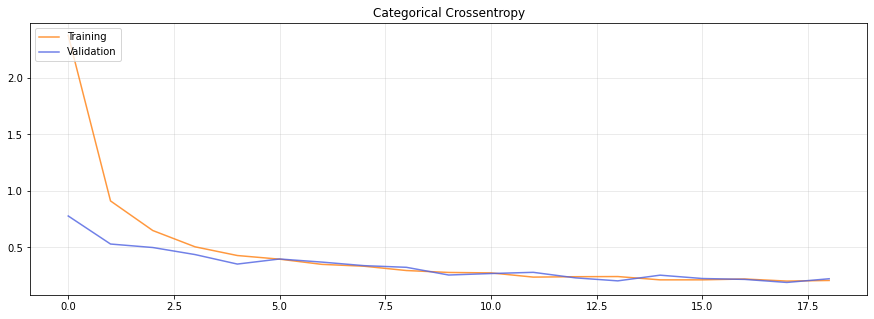

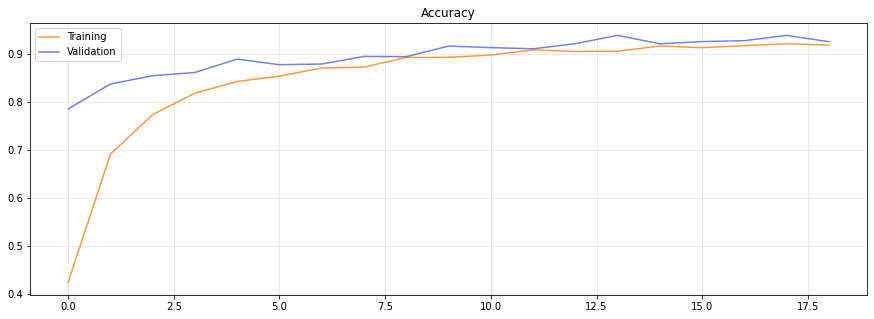

In [21]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()